In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
import numpy.random as npr
import numpy as np
import random
from sklearn.model_selection import train_test_split
from datetime import datetime

### Section 1 - Forward

In [ ]:
def initialize_parameters(layer_dims):
    parameters = {}
    n_layers = len(layer_dims)

    for l in range(1, n_layers):
        parameters[f'W{l}'] = npr.randn(layer_dims[l], layer_dims[l - 1]) * (np.sqrt(2. / layer_dims[l - 1]))
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))

    return parameters

def linear_forward(a, w, b):
    z = np.dot(w, a) + b
    linear_cache = {"A": a, "W": w, "B": b}
    return z, linear_cache

def softmax(z):
    shiftz = z - np.max(z)
    a = np.divide(np.exp(shiftz), np.sum(np.exp(shiftz), axis=0))
    return a, {"z": z, "activation_function": "softmax"}

def relu(z):
    a = np.maximum(0, z)
    return a, {"z": z, "activation_function": "relu"}


def linear_activation_forward(a_prev, w, b, activation):
    linear_cache = {}
    activation_cache = {}

    z, linear_cache = linear_forward(a_prev, w, b)
    a, activation_cache = relu(z) if activation == "relu" else softmax(z)

    return a, {"linear_cache": linear_cache, "activation_cache": activation_cache}


def l_model_forward(x, parameters, use_batchnorm):
    caches = []
    n_layers = len(parameters) // 2
    # Using a for loop to replicate [LINEAR->RELU] (L-1) times
    a = x
    for l in range(1, n_layers):
        a, cache = linear_activation_forward(a, parameters[f'W{l}'], parameters[f'b{l}'], "relu")
        a = apply_batchnorm(a) if use_batchnorm else a
        caches.append(cache)

    # Activation of last layer is softmax function
    al, cache = linear_activation_forward(a, parameters[f'W{n_layers}'], parameters[f'b{n_layers}'], "softmax")
    caches.append(cache)
    return al, caches


def compute_cost(al, y):
    loss = np.sum(np.multiply(y, np.log(al))+ np.multiply(1-y,np.log(1-al)))
    cost = -(1. / y.shape[1]) * loss
    return cost

def apply_batchnorm(a):
    epsilon = 1e-5
    mu = np.mean(a, axis=0)
    var = np.var(a, axis=0)

    return (a - mu) / np.sqrt(var + epsilon)

### Section 2 - Backward

In [ ]:
def linear_backward(dz, cache):
    a_prev, w = cache["A"], cache["W"]
    m = dz.shape[0]

    dw = np.dot(dz, a_prev.T) / m
    db = np.sum(dz, axis=1, keepdims=True) / m
    da_prev = np.dot(w.T, dz)

    return da_prev, dw, db


def linear_activation_backward(da, cache, activation):
    linear_cache = cache["linear_cache"]
    activation_cache = cache["activation_cache"]

    activation_function = relu_backward if activation == "relu" else softmax_backward
    dz = activation_function(da, activation_cache)
    da_prev, dw, db = linear_backward(dz, linear_cache)
    return da_prev, dw, db



def relu_backward(da, activation_cache):
    z = activation_cache["z"]
    dz = np.array(da, copy=True)
    dz[z <= 0] = 0
    dz[z > 0] = 1
    return da * dz


def softmax_backward(da, activation_cache):
    z = activation_cache["z"]
    return da


def l_model_backward(al, y, caches):
    grads = {}
    n_layers = len(caches)

    dal = al - y
    da, dw, db = linear_activation_backward(dal, caches[-1], 'softmax')
    grads[f'dW{n_layers}'] = dw
    grads[f'db{n_layers}'] = db

    for l in range(n_layers - 1, 0, -1):
        current_cache = caches[l - 1]
        grads[f'dA{l}'] = da
        da, dw, db = linear_activation_backward(da, current_cache, 'relu')
        grads[f'dW{l}'] = dw
        grads[f'db{l}'] = db

    return grads


def update_parameters(parameters, grads, learning_rate):
    n_parameters = len(parameters) // 2

    for l in range(n_parameters):
        parameters[f'W{l + 1}'] -= learning_rate * grads[f'dW{l + 1}']
        parameters[f'b{l + 1}'] -= learning_rate * grads[f'db{l + 1}']

    return parameters


### Section 3 - Model

In [ ]:
def l_layer_model(x, y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm):
    # keep track of cost
    costs = []
    threshold = 1e-3

    # Split to validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=4)
    x_train, y_train = x_train.T, y_train.T
    n_samples = len(x_train)
    n_batches = -(-n_samples // batch_size)

    # Parameters initialization.
    parameters = initialize_parameters(layers_dims)

    i = 1
    # define early stopping if the improvment is less than defined thershold 
    while (len(costs) < 2 or abs(costs[-2] - costs[-1]) > threshold) and i <= num_iterations:
        begin = batch_size * ((i - 1) % n_batches)
        end = min(begin + batch_size, n_samples)

        x_batch = x_train[:, begin:end]
        y_batch = y_train[:, begin:end]

        al, caches = l_model_forward(x_batch, parameters, use_batchnorm)

        if (i % 100) == 0:
            al_val, caches_val = l_model_forward(x_val.T, parameters, use_batchnorm)
            cost_validation = compute_cost(al, y_batch)
            acc = predict(x_val, y_val, parameters) * 100
            
            costs.append(cost_validation)
            print(f'{i:>5} iterations: validation set cost={costs[-1]:.4f} accuracy={acc:.2f}')
        
        grads = l_model_backward(al, y_batch, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        i += 1

    accuarcy_validation = predict(x_val, y_val, parameters)
    print('Accuarcy on validation set:', accuarcy_validation)
    return parameters, costs


def predict(x, y, parameters):
    x, y = x.T, y.T
    len_predictions = x.shape[1]
    al, caches = l_model_forward(x, parameters, use_batchnorm= False)
    nearest_node = np.argmax(al, axis=0)
    test_real_value = np.argmax(y, axis=0)
    correct = np.sum(nearest_node == test_real_value) / float(len_predictions)
    return correct

### Section 4 - Test in MNIST dataset

In [ ]:
def train(n_iterations, batch_size, lr, use_batchnorm):
    # load MNIST from keras
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(x_train.shape[0], 28 * 28) # 784
    x_test = x_test.reshape(x_test.shape[0], 28 * 28)

    x_train = x_train.astype('float64')
    x_test = x_test.astype('float64')

    x_train = x_train / 255
    x_test = x_test / 255

    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y_train = y_train.reshape(x_train.shape[0], 1)
    y_test = y_test.reshape(x_test.shape[0], 1)
    y_train = np_utils.to_categorical(y_train, num_classes=10)
    y_test = np_utils.to_categorical(y_test, num_classes=10)

    st = datetime.now()
    parameters, costs = l_layer_model(x=x_train,
                                      y=y_train,
                                      layers_dims=[x_train.shape[1], 20, 7, 5, 10],
                                      learning_rate=lr,
                                      num_iterations=n_iterations,
                                      batch_size=batch_size,
                                      use_batchnorm=use_batchnorm)
    duration = (datetime.now()-st).total_seconds()
    
    # Compute accuracy
    accuarcy_test = predict(x_test, y_test, parameters, use_batchnorm)
    accuarcy_train = predict(x_train, y_train, parameters, use_batchnorm)

    print('Accuarcy on train set:', accuarcy_train)
    print('Accuarcy on test set:', accuarcy_test)
    print(f'Training duration: {duration:.2f} seconds')

    # plot the cost
    plt.figure(figsize=(18, 6))
    plt.plot([(i + 1) * 100 for i in range(len(costs))], costs)
    plt.ylabel('cost')
    plt.xlabel('Iterations')
    plt.title(f'Learning rate = {lr}')
    plt.show()

  100 iterations: validation set cost=1.6518 accuracy=54.50
  200 iterations: validation set cost=1.2158 accuracy=66.74
  300 iterations: validation set cost=0.8742 accuracy=75.18
  400 iterations: validation set cost=0.0457 accuracy=81.88
  500 iterations: validation set cost=0.0175 accuracy=82.03
  600 iterations: validation set cost=0.0107 accuracy=82.02
  700 iterations: validation set cost=0.0075 accuracy=81.89
  800 iterations: validation set cost=0.0056 accuracy=81.99
  900 iterations: validation set cost=0.0044 accuracy=81.97
 1000 iterations: validation set cost=0.0035 accuracy=82.03
Accuarcy on validation set: 0.82025
Accuarcy on train set: 0.8196333333333333
Accuarcy on test set: 0.8254
Training duration: 4.73 seconds


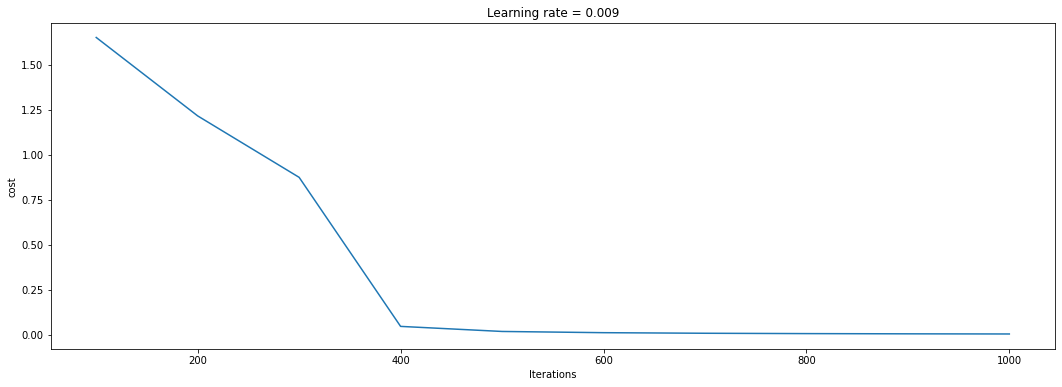

In [ ]:
random.seed(123)
train(50000, 240, lr =0.009, use_batchnorm=False)

  100 iterations: validation set cost=1.5112 accuracy=64.18
  200 iterations: validation set cost=0.6744 accuracy=77.98
  300 iterations: validation set cost=0.2558 accuracy=78.43
  400 iterations: validation set cost=0.0845 accuracy=81.33
  500 iterations: validation set cost=0.0618 accuracy=81.42
  600 iterations: validation set cost=0.0701 accuracy=81.48
  700 iterations: validation set cost=0.0220 accuracy=81.55
  800 iterations: validation set cost=0.0543 accuracy=81.67
  900 iterations: validation set cost=0.0251 accuracy=81.60
 1000 iterations: validation set cost=0.0076 accuracy=81.67
 1100 iterations: validation set cost=0.0072 accuracy=81.70
Accuarcy on validation set: 0.81675
Accuarcy on train set: 0.8200166666666666
Accuarcy on test set: 0.8263
Training duration: 3.68 seconds


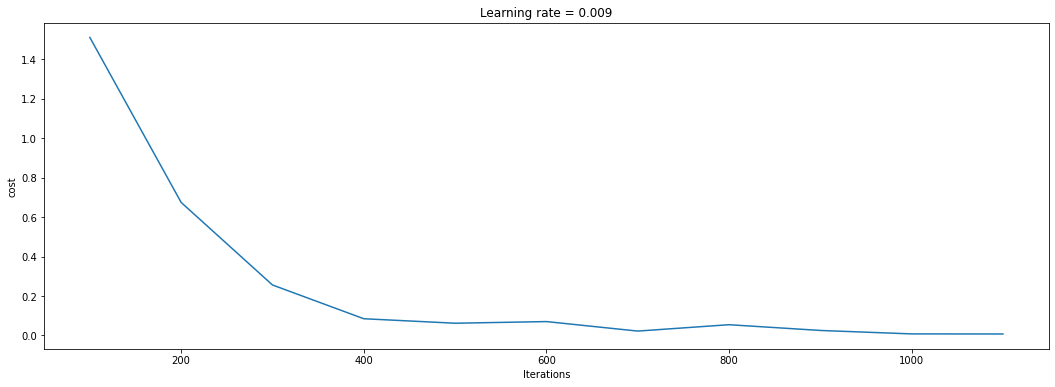

In [ ]:
random.seed(123)
train(50000, 120, lr =0.009, use_batchnorm=False)

  100 iterations: validation set cost=2.9317 accuracy=26.01
  200 iterations: validation set cost=2.6487 accuracy=31.06
  300 iterations: validation set cost=2.4296 accuracy=33.70
  400 iterations: validation set cost=2.4020 accuracy=40.28
  500 iterations: validation set cost=2.4234 accuracy=39.81
  600 iterations: validation set cost=2.2444 accuracy=45.37
  700 iterations: validation set cost=2.3230 accuracy=46.14
  800 iterations: validation set cost=2.1739 accuracy=49.81
  900 iterations: validation set cost=2.0827 accuracy=50.22
 1000 iterations: validation set cost=1.8224 accuracy=56.33
 1100 iterations: validation set cost=1.6882 accuracy=59.65
 1200 iterations: validation set cost=1.6054 accuracy=57.14
 1300 iterations: validation set cost=1.4694 accuracy=60.38
 1400 iterations: validation set cost=1.4287 accuracy=61.25
 1500 iterations: validation set cost=1.4314 accuracy=60.88
 1600 iterations: validation set cost=1.1674 accuracy=67.16
 1700 iterations: validation set cost=1.

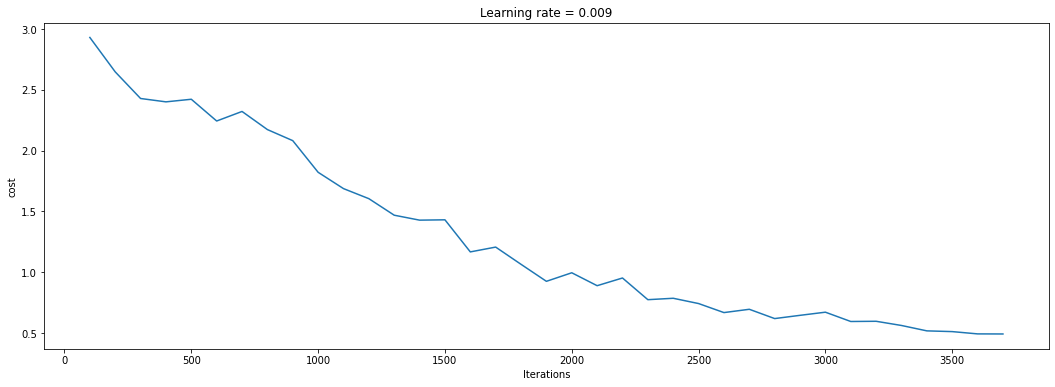

In [ ]:
random.seed(123)
train(50000, 240, lr = 0.009, use_batchnorm=True)

  100 iterations: validation set cost=3.1220 accuracy=15.28
  200 iterations: validation set cost=2.9668 accuracy=21.99
  300 iterations: validation set cost=2.8063 accuracy=22.62
  400 iterations: validation set cost=2.6769 accuracy=25.77
  500 iterations: validation set cost=2.8178 accuracy=26.73
  600 iterations: validation set cost=2.5358 accuracy=27.55
  700 iterations: validation set cost=2.5916 accuracy=29.20
  800 iterations: validation set cost=2.7953 accuracy=30.40
  900 iterations: validation set cost=2.7556 accuracy=28.63
 1000 iterations: validation set cost=2.5703 accuracy=31.23
 1100 iterations: validation set cost=2.4000 accuracy=30.75
 1200 iterations: validation set cost=2.5195 accuracy=29.71
 1300 iterations: validation set cost=2.2513 accuracy=29.55
 1400 iterations: validation set cost=2.5757 accuracy=31.97
 1500 iterations: validation set cost=2.4381 accuracy=33.63
 1600 iterations: validation set cost=2.6716 accuracy=33.94
 1700 iterations: validation set cost=2.

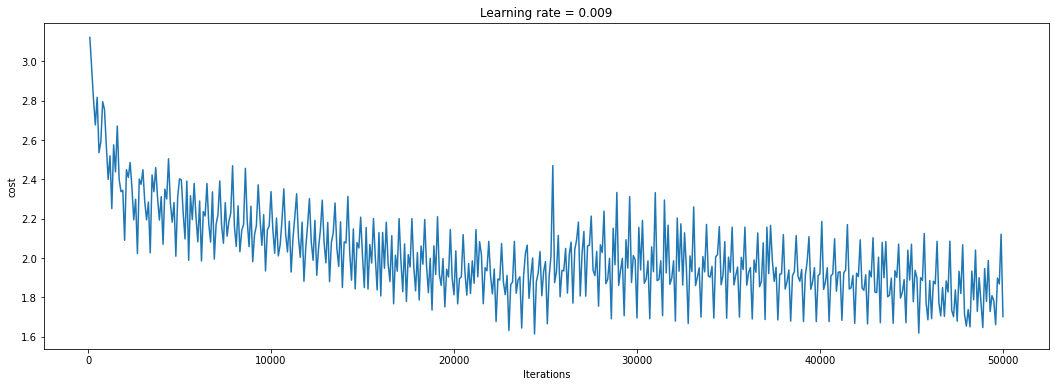

In [ ]:
random.seed(123)
train(50000, 120, lr = 0.009, use_batchnorm=True)

  100 iterations: validation set cost=3.1543 accuracy=17.11
  200 iterations: validation set cost=3.1389 accuracy=18.00
  300 iterations: validation set cost=2.9507 accuracy=18.75
  400 iterations: validation set cost=2.9396 accuracy=18.60
  500 iterations: validation set cost=2.9503 accuracy=18.41
  600 iterations: validation set cost=2.9203 accuracy=18.62
  700 iterations: validation set cost=2.8748 accuracy=19.04
  800 iterations: validation set cost=2.8664 accuracy=19.73
  900 iterations: validation set cost=2.8461 accuracy=20.18
 1000 iterations: validation set cost=2.8784 accuracy=19.39
 1100 iterations: validation set cost=2.8205 accuracy=20.17
 1200 iterations: validation set cost=2.8480 accuracy=19.80
 1300 iterations: validation set cost=2.7306 accuracy=22.14
 1400 iterations: validation set cost=2.6834 accuracy=21.94
 1500 iterations: validation set cost=2.6718 accuracy=22.24
 1600 iterations: validation set cost=2.6359 accuracy=23.83
 1700 iterations: validation set cost=2.

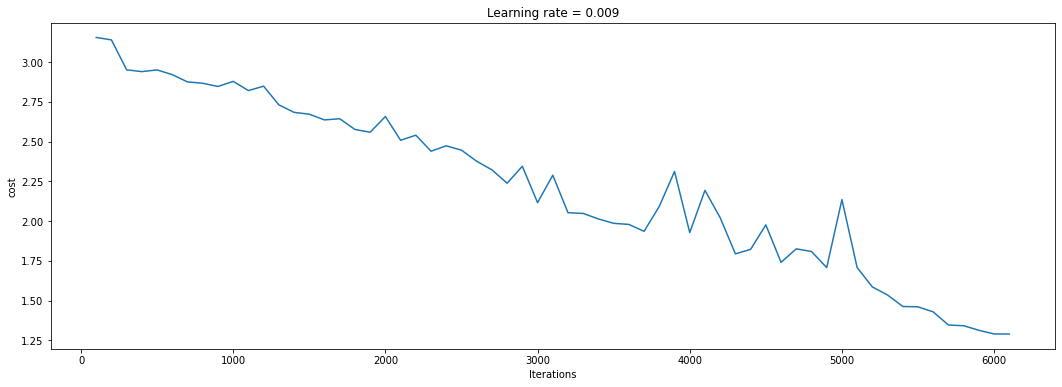

In [ ]:
random.seed(123)
train(50000, 480, lr = 0.009, use_batchnorm=True)